<a href="https://colab.research.google.com/github/esa-prakasa/autov/blob/master/binary_lane_4_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load dan mount Google Drive
from google.colab import drive

# Pilihan user authorization dengan menggunakan account Google
drive.mount('/content/drive')

# Pilihan user authorization dengan menggunakan account Google

path = "/content/drive/My Drive/Colab Notebooks/dataset"
#!ls -l "/content/drive/My Drive/Colab Notebooks/dataset"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


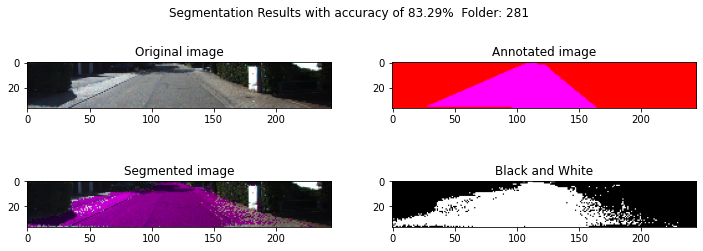

In [12]:
import cv2
import os
import matplotlib.pyplot as plt

folderCode = "203/"
folderCode = "204/"
folderCode = "205/"
folderCode = "206/"
folderCode = "207/"
folderCode = "210/"
folderCode = "249/"
folderCode = "270/"
folderCode = "273/"
folderCode = "281/"

imgPath = "/content/drive/My Drive/Colab Notebooks/dataset/rdtest/"+folderCode


fileList = []


for r, d, f in os.walk(imgPath):
		for file in f:
			typeCode = file[:4]
			if typeCode == "aOri":
				oriImgF = file
			if typeCode == "bLab":
				labImgF = file

oriImg = cv2.imread(os.path.join(r,oriImgF))
labImg = cv2.imread(os.path.join(r,labImgF))

'''
for r, d, f in os.walk(imgPath):
		for file in f:
			typeCode = file[:3]
			if typeCode == "lbl":
				lblImg = file
			if typeCode == "tgt":
				tgtImg = file

oriImg = cv2.imread(os.path.join(r,tgtImg))
labImg = cv2.imread(os.path.join(r,lblImg))
'''

M = labImg.shape[0]
N = labImg.shape[1]

b,g,r =  cv2.split(oriImg)
oriImgRGB = cv2.merge([r,g,b])

b,g,r =  cv2.split(labImg)
labImgRGB = cv2.merge([r,g,b])

'''
fig, axs = plt.subplots(2,1)
fig.suptitle("Input Image")
axs[0].set_title('Original image')
axs[0].imshow(oriImgRGB)

axs[1].set_title('Annotated image')
axs[1].imshow(labImgRGB)
plt.show()
'''
import numpy as np

M = labImg.shape[0]
N = labImg.shape[1]

#print(M)
#print(N)

X = np.zeros((M*N, 5))
Y = np.zeros((M*N, 1))

roadClass = 0

idx = 0
for i in range(M):
  for j in range (N):
    #print(idx)
    X[idx, 0] = i
    X[idx, 1] = j
    X[idx, 2] = oriImg[i,j,2]   #r
    X[idx, 3] = oriImg[i,j,1]   #g
    X[idx, 4] = oriImg[i,j,0]   #b
    
    bRef = labImg[i,j,0]

    if (bRef==0):  ##>>> Non Road
      roadClass = 0
    if (bRef==255):   ##>>> ROAD
      roadClass = 1
    
    Y[idx, 0] = roadClass
    idx = int(idx + 1)

X0 = X.copy()
#print(idx)
#print(X)
#print(Y)

#standardizing the input feature
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = X
Y_test = Y
from keras.models import model_from_json
path = "/content/drive/My Drive/Colab Notebooks/dataset/"


# load json and create model
json_file = open((path+'road_model_20pct200.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path+"road_wg_model_20pct200.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
result = loaded_model.predict(X_test)
finClass = np.round(result)
c3 = [result, finClass]


Nx = len(c3[0])

segImg = oriImg.copy()
bwImg = oriImg.copy()

for i in range(Nx):
  
  ii = int(X0[i,0])
  jj = int(X0[i,1])
  clsIdx = int(c3[1][i])
  if (clsIdx == 1):
    segImg[ii,jj,1] = 0
    bwImg[ii,jj,0] = 255
    bwImg[ii,jj,1] = 255
    bwImg[ii,jj,2] = 255
  if (clsIdx == 0):
    bwImg[ii,jj,0] = 0
    bwImg[ii,jj,1] = 0
    bwImg[ii,jj,2] = 0

#  if (clsIdx == 0):
#    pass
 # print("%d %d %d "%(ii, jj, clsIdx))


b,g,r =  cv2.split(segImg)
segImgRGB = cv2.merge([r,g,b])

fig, axs = plt.subplots(2,2,figsize=(12,4))
#fig= plt.figure(figsize=(600,300))

#fig.suptitle("Segmentation Results with accuracy of %.2f%%"%(score[1]*100))
fig.suptitle("Segmentation Results with accuracy of %.2f%%  Folder: %s "%((score[1]*100),folderCode[:-1]))

axs[0,0].set_title('Original image')
axs[0,0].imshow(oriImgRGB)

axs[0,1].set_title('Annotated image')
axs[0,1].imshow(labImgRGB)


axs[1,0].set_title('Segmented image')
axs[1,0].imshow(segImgRGB)

axs[1,1].set_title('Black and White')
axs[1,1].imshow(bwImg)

plt.show()

del segImg